<div class="alert alert-block alert-info" style="text-align: center; color: black">
    <h1 style="color: #002AFF">A Butterfly in COVID:<br>Structural Racism and Baltimore's Pretrial Legal System</h1>
    <h2>Code Supporting Article Analysis and Images</h2>
</div>


<p> This notebook is the source of data, analysis, and code behind the claims made in <span style="font-weight: bold">A Butterfly in COVID: Structural Racism and Baltimore's Pretrial Legal System</span> by Doug Colbert and Colin Starger. The code is written in Python.</p>

<p>To assist in verification, the notebook uses <span style="color:red">RED PAGE NUMBERS</span> to refer to pages in the article where claims are made. In addition, <span style="font-weight: bold">FIGURES</span> are also separatedly labelled with large headers.</p>

In [1]:
#Libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import datetime as dt
from datetime import date
from geopandas import GeoDataFrame
from shapely.geometry import Polygon, LineString, Point
from shapely import wkt

In [2]:
#Load API information for BNIA indicators
#Will use for helping with ShortName
api_df = pd.read_csv("VS-Indicator-APIs.csv")
api_df.set_index("ShortName", inplace=True) #Makes the dataframe index the shortname
api_df.head(2) #This code simply shows the first two rows of the file

,Indicator Number,Indicator,Section,API
ShortName,,,,
tpopXX,1,Total Population,Census Demographics,https://services1.arcgis.com/mVFRs7NF4iFitgbY/...
maleXX,2,Total Male Population,Census Demographics,https://services1.arcgis.com/mVFRs7NF4iFitgbY/...


In [3]:
#Functions to access the BNIA API
def getGDFfromURL(url, layer=0):
    #GDF stands for GeoDataFrame; this is the innermost function called by getGDF
    tail = "/"+str(layer)+"/query?where=1%3D1&outFields=*&outSR=4326&f=json" #worked this out
    url+=tail
    print(url)
    gdf = gpd.read_file(url) #GeoPandas has a built in function to read APIs given right URL
    return gdf

def getGDF(shortname, level=0):
    #This is outermost function called by user; it calls getGDFfromURL
    url = api_df.loc[shortname, "API"]
    return getGDFfromURL(url, level)

In [4]:
#Global vars

#List of "reverse indicators" - where LESS should be lighter (as opposed to standard MORE=lighter)
reverse_list=["kraXX", "hfaiXX", "regvoteXX", "pwhiteXX", "mhhiXX", "ownrocXX", "lifexpXX", "votedXX", 'libcardXX', 'hfaiXX', 'readyXX']

#Need this for REVERSE cmaps (without reference to the XX)
new_reverse_list=[]
for r in reverse_list:
    new_reverse_list.append(r[:-2])

#These are the 16 indicators I settled on as most relevant
master_list= [['paaXX', 'femhhsXX', 'mhhiXX', 'hhpovXX'],
             ['hhchpovXX', 'ownrocXX', 'vacantXX', 'nohhintXX'],
             ['tanfXX', 'lifexpXX', 'votedXX', 'abshsXX'],
             ['nilfXX','lesshsXX', 'pubtranXX', 'novhclXX']]

api_shortname= {
    'paa': '% Residents Black',
'femhhs': 'X% Female-Led Households w/ Children Under 18',
'mhhi': 'Median Household Income',
'hhpov': '% Family Households Below Poverty Line',
'hhchpov': '% Children Below Poverty Line',
'ownroc': '% Housing Units Owner-Occupied',
'vacant': '% Residential Properties Vacant and Abandoned',
'nohhint': '% Households w/ No Home Internet',
'tanf': '% Families Receiving TANF',
'lifexp': 'Life Expectancy',
'voted': '% Over 18 Population Voted General Election',
'abshs': '% 9th-12th Grade Chronically Absent (Missing > 19 days)',
'nilf': '% Population 16-64 Not in Labor Force',
'lesshs': '% Over 25 Years Population w/no High School Diploma or GED',
'pubtran': '% Population Using Public Transportation to Work',
'novhcl': '% Households w/ No Vehicles Available'
}

#Global cmaps - Viz color schemes
pu_seq = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

seq1 = [ 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
seq2 = ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']

In [5]:
#Turbo_gdf is the saved list of latest master_list indictors
#Use neighborhood as the index

df = pd.read_csv("collected_indicators.csv")
df['geometry'] = df['geometry'].apply(wkt.loads)
turbo_gdf = gpd.GeoDataFrame(df, crs='epsg:4326')
turbo_gdf= turbo_gdf.set_index("CSA2010", drop=True)

In [6]:
#Create as a reference GDF - strictly with neighborhood geometry
ref_df= getGDF("paaXX")[["CSA2010", "Shape__Area", "Shape__Length", "geometry"]]

#Function to get the CSA given longitude and latitude
#If point is not in CSA, return False
def getCSA(long,lat):
    #Uses ref_df
    point = Point(long,lat)
    sub_df=ref_df[ref_df["geometry"].contains(point)]
    if len(sub_df):
        return sub_df.iloc[0,0]
    else:
        return(False)

#For use in apply functions on dataframes 
def pullCSA(row):
    long = row.Long
    lat = row.Lat
    return (getCSA(long, lat))

https://services1.arcgis.com/mVFRs7NF4iFitgbY/arcgis/rest/services/Paa/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json


<h2 style="text-align: center; color: red">Page 4</h2>

In [7]:
#Create Census Table
#Using BNIA API
targets = ["tpopXX","paaXX","pwhiteXX","pasiXX", "p2moreXX", "ppacXX", "phispXX"]

census_df=pd.DataFrame(columns=["Indicator", "2010 Pop", "2010 Pct", "2020 Pop", "2020 Pct"], index=targets)

for target in targets:
    indicator= api_df.loc[target,"Indicator"]
    temp_df=getGDF(target,1)
    #2020
    col=temp_df.columns.to_list()[-4]
    #year2=col[-2:]
    pct_20 = round(temp_df.loc[0,col],2)
    #2010
    col=temp_df.columns.to_list()[2]
    #year1=col[-2:]
    pct_10 = round(temp_df.loc[0,col],2)
    
    census_df.loc[target] = {"Indicator":indicator, "2010 Pct":pct_10, "2020 Pct":pct_20}

#Clean Up Population
pop_10=census_df.loc["tpopXX", "2010 Pct"] 
pop_20=census_df.loc["tpopXX", "2020 Pct"]

census_df = census_df.drop("tpopXX")

#2010 percentages add up to slightly more than 100%
#print(round(census_df["2010 Pct"].apply(lambda x: pop_10 * x/100),0).sum())
census_df["2010 Pop"] = round(census_df["2010 Pct"].apply(lambda x: pop_10 * x/100),0).astype("int")
census_df["2020 Pop"] = round(census_df["2010 Pct"].apply(lambda x: pop_20 * x/100),0).astype("int")

remove = "Percent of Residents - "
census_df["Indicator"].apply(lambda x: x[len(remove):])

print("2010 Population", pop_10)
print("2020 Population", pop_20)
print("Decline = ", round(100-(pop_20/pop_10*100),2))


https://services1.arcgis.com/mVFRs7NF4iFitgbY/arcgis/rest/services/Tpop/FeatureServer/1/query?where=1%3D1&outFields=*&outSR=4326&f=json
https://services1.arcgis.com/mVFRs7NF4iFitgbY/arcgis/rest/services/Paa/FeatureServer/1/query?where=1%3D1&outFields=*&outSR=4326&f=json
https://services1.arcgis.com/mVFRs7NF4iFitgbY/arcgis/rest/services/Pwhite/FeatureServer/1/query?where=1%3D1&outFields=*&outSR=4326&f=json
https://services1.arcgis.com/mVFRs7NF4iFitgbY/arcgis/rest/services/Pasi/FeatureServer/1/query?where=1%3D1&outFields=*&outSR=4326&f=json
https://services1.arcgis.com/mVFRs7NF4iFitgbY/arcgis/rest/services/P2more/FeatureServer/1/query?where=1%3D1&outFields=*&outSR=4326&f=json
https://services1.arcgis.com/mVFRs7NF4iFitgbY/arcgis/rest/services/Ppac/FeatureServer/1/query?where=1%3D1&outFields=*&outSR=4326&f=json
https://services1.arcgis.com/mVFRs7NF4iFitgbY/arcgis/rest/services/Phisp/FeatureServer/1/query?where=1%3D1&outFields=*&outSR=4326&f=json
2010 Population 620961
2020 Population 58570

In [8]:
#ECHO CENSUS TABLE
census_df

,Indicator,2010 Pop,2010 Pct,2020 Pop,2020 Pct
paaXX,Percent of Residents - Black/African-American ...,396297,63.82,373799,57.3
pwhiteXX,Percent of Residents - White/Caucasian (Non-Hi...,175608,28.28,165638,26.86
pasiXX,Percent of Residents - Asian (Non-Hispanic),14530,2.34,13706,3.59
p2moreXX,Percent of Residents - Two or More Races (Non-...,10556,1.7,9957,3.6
ppacXX,Percent of Residents - All Other Races (Hawaii...,3043,0.49,2870,0.81
phispXX,Percent of Residents - Hispanic,26205,4.22,24717,7.84


In [9]:
#Key DATA SOURCE
#all_defs_df contains main defendant data of the study

# This file contains original names and is not available on public GitHub Repo
#all_defs_df = pd.read_csv("all_defs_pretrial-asa.csv", parse_dates=["balr_date"])

# This file uses pseudonymns
all_defs_df = pd.read_csv("all_defs_psynym.csv", parse_dates=["balr_date"])

#Copy the neighborhood code from stories_df
#stories_df["CSA"]=stories_df.apply(pullCSA, axis=1)
all_defs_df["CSA"]=all_defs_df.apply(pullCSA, axis=1)
x_coords = all_defs_df["Long"].tolist()
y_coords = all_defs_df["Lat"].tolist()

In [10]:
#Glimpse at all_defs
all_defs_df.head(2)

,def_index,Psynym,Race,balr_date,judge_name,Outcome,pretrial_rec,asa_rec,Long,Lat,CSA
0,0,Conan Niwman,AA,2020-06-01,Boles,UPB,HWOB,-1,-76.687531,39.276342,Allendale/Irvington/S. Hilton
1,1,Troy Huwkes,AA,2020-06-01,Boles,HWOB,HWOB,HWOB,-76.599806,39.362196,Chinquapin Park/Belvedere


In [11]:
#casenumber df for reference
dc_caseno_df = pd.read_csv("dc_casenumbers.csv")

In [12]:
#This gives number of defendants
len(all_defs_df)

509

In [13]:
# Will now add our study indicators to turbo_gdf
# Can use for correlation and mapping
# Want to make a generic function
# Then add columns

def getCSATotals(filter_df):
    result={}
    for csa in turbo_gdf.index:
        result[csa]=len(filter_df[filter_df.CSA==csa])
    return result

filter_df = all_defs_df
turbo_gdf["all_defs"]=getCSATotals(filter_df).values()

filter_df = all_defs_df[all_defs_df.Outcome=="HWOB"]
turbo_gdf["hwob_defs"]=getCSATotals(filter_df).values()

filter_df = all_defs_df[all_defs_df.Race=="AA"]
turbo_gdf["black_defs"]=getCSATotals(filter_df).values()

filter_df = all_defs_df[all_defs_df.Race=="W"]
turbo_gdf["white_defs"]=getCSATotals(filter_df).values()

In [14]:
#Plotting function
def getAscend(target):
    #Using new_reverse_list global var here
    ascend= False
    if (target[:-2] in new_reverse_list):
        ascend= True
    return ascend


def createCSA_Chloro(ax, target, num_show=55, reverse=False):
    cmap="plasma_r"
    ascend = getAscend(target)
    
    if ascend:
        cmap="plasma"
    
    if reverse:
        if ascend==True:
            ascend=False
        else:
            ascend=True
    
    map_gdf = turbo_gdf.sort_values(by=target, ascending=ascend)
    map_gdf.plot(target, cmap=cmap, ax=ax)
    if num_show < 55:
        map_gdf.iloc[num_show:].plot(color="white", edgecolor="white", ax=ax)


<h1 style="text-align:center; color:black"> Figure 1 Maps</h1>
<h1 style="text-align:center; color:red"> Page 4</h1>

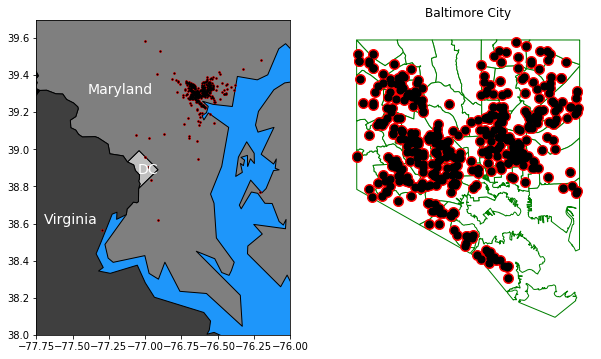

In [15]:
#Use US boundaries, focus on MD region
usa_gdf=gpd.read_file("USA_States_(Generalized).geojson")
usa_gdf["STATE_NAME"].unique()


states=['Delaware','Maryland','District of Columbia','Virginia', 'West Virginia']
dmv_gdf= usa_gdf[usa_gdf["STATE_NAME"].isin(states)]

#fisize=(6, 6)
rows=1
cols=2
#fig, ax= plt.subplots(rows, cols, figsize=figsize)
fig, ax= plt.subplots(rows, cols)
fig.set_size_inches(10,10)

#Map 1 - Big Picture 
cmap='binary'
dmv_gdf.plot("STATE_NAME", ax=ax[0], edgecolor="black", cmap=cmap)
ax[0].set_facecolor("#1e96fa")

#Zoom
outer_xlim= (-77.75, -76)
outer_ylim= (38, 39.7)
ax[0].set_xlim(outer_xlim)
ax[0].set_ylim(outer_ylim)

#State labels
md_label=(-77.4, 39.3)
va_label = (-77.7, 38.6)
dc_label = (-77.05, 38.87)
font_size=14
label_color="white"
ax[0].annotate("Maryland", color=label_color, xy=md_label, size=font_size)
ax[0].annotate("Virginia", color=label_color, xy=va_label, size=font_size)
ax[0].annotate("DC", color=label_color, xy=dc_label, size=font_size)

#Scatter of defs
ax[0].scatter(x=x_coords, y=y_coords, s=3, color="red")
ax[0].scatter(x=x_coords, y=y_coords, s=1, color="black")

#Turn off Lat/Long
#ax[0].set_axis_off()

#Map 2 - Big Picture 
turbo_gdf.plot(color="white", ax=ax[1], edgecolor="green")

#Scatter of defs
balt_defs= all_defs_df[all_defs_df["CSA"]!=False]
balt_x_coords = balt_defs["Long"].tolist()
balt_y_coords = balt_defs["Lat"].tolist()
ax[1].scatter(x=balt_x_coords, y=balt_y_coords, s=100, color="red")
ax[1].scatter(x=balt_x_coords, y=balt_y_coords, s=50, color="black")

ax[1].set(title="Baltimore City")

ax[1].set_axis_off()

In [22]:
#Functions to help visualize and analyze CSA data
def showCSA(csa):
    fig, ax = plt.subplots()
    turbo_gdf.plot(color="white", edgecolor="green", ax=ax)
    turbo_gdf[turbo_gdf.index==csa].plot(color="green", ax=ax)
    return True

def get_CSA_rank(csa, indicator):
    raw = turbo_gdf.loc[csa,indicator]
    rank = turbo_gdf[indicator].rank(ascending=False)[csa]
    return (raw,rank)

def get_All_CSA_ranks(csa):
    target_cols = list(turbo_gdf.columns)[1:]
    result_df=pd.DataFrame(index=target_cols, columns=["Indic", "Name", "Raw", "Rank"])
    for target in target_cols:
        raw, rank = get_CSA_rank(csa, target)
        #Hack
        name=target
        if name[0:-2] in api_shortname:
            name = api_shortname[name[0:-2]]
        
        result_df.loc[target]={"Indic":target, "Name":name, "Raw":raw, "Rank":rank}
    return result_df
        
def findName(name):
    
    #return all_defs_df[all_defs_df["Name"].str.contains(name, case=False)][["Name", "Race", "Outcome","CSA", "pretrial_rec", "asa_rec"]]
    return all_defs_df[all_defs_df["Psynym"].str.contains(name, case=False)][["Psynym", "Race", "Outcome","CSA", "pretrial_rec", "asa_rec"]]


<h1 style="text-align:center; color:red">Page 6</h1>

In [23]:
# Zoey Griffin
# Zoey Griffin's real name is used because this person tragically passed. Privacy issues are not the same
findName("Griffin")

,Psynym,Race,Outcome,CSA,pretrial_rec,asa_rec
215,Zoey Griffin,AA,HWOB,Westport/Mount Winans/Lakeland,HWOB,HWOB


In [24]:
dc_caseno_df[dc_caseno_df.def_index==215]

,def_index,dc_casenumber
249,215,4B02423005


True

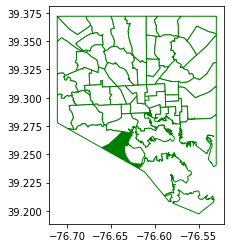

In [25]:
csa="Westport/Mount Winans/Lakeland"
showCSA(csa)

In [26]:
#Look at Mr. Griffin's relative rankings
get_All_CSA_ranks(csa)

,Indic,Name,Raw,Rank
paa20,paa20,% Residents Black,51.5858,36
femhhs19,femhhs19,X% Female-Led Households w/ Children Under 18,72.6877,9
mhhi19,mhhi19,Median Household Income,35923.2,41
hhpov19,hhpov19,% Family Households Below Poverty Line,24.0463,16
hhchpov19,hhchpov19,% Children Below Poverty Line,43.1923,13
ownroc20,ownroc20,% Housing Units Owner-Occupied,42.4919,38
vacant20,vacant20,% Residential Properties Vacant and Abandoned,7.39191,17
nohhint19,nohhint19,% Households w/ No Home Internet,25.1208,24
tanf19,tanf19,% Families Receiving TANF,7.72834,24
lifexp18,lifexp18,Life Expectancy,72.1852,27


In [27]:
#Median Household Income Ranks
turbo_gdf["mhhi19"].rank(ascending=False) 

CSA2010
Allendale/Irvington/S. Hilton            32.0
Beechfield/Ten Hills/West Hills          19.0
Belair-Edison                            26.0
Brooklyn/Curtis Bay/Hawkins Point        36.0
Canton                                    1.0
Cedonia/Frankford                        25.0
Cherry Hill                              51.0
Chinquapin Park/Belvedere                17.0
Claremont/Armistead                      42.0
Clifton-Berea                            44.0
Cross-Country/Cheswolde                  15.0
Dickeyville/Franklintown                 30.0
Dorchester/Ashburton                     24.0
Downtown/Seton Hill                      13.0
Edmondson Village                        31.0
Fells Point                               6.0
Forest Park/Walbrook                     29.0
Glen-Fallstaff                           35.0
Greater Charles Village/Barclay          27.0
Greater Govans                           34.0
Greater Mondawmin                        45.0
Greater Roland Park/Poplar

In [28]:
get_All_CSA_ranks("Canton")

,Indic,Name,Raw,Rank
paa20,paa20,% Residents Black,3.90824,55
femhhs19,femhhs19,X% Female-Led Households w/ Children Under 18,15.0224,51
mhhi19,mhhi19,Median Household Income,128460,1
hhpov19,hhpov19,% Family Households Below Poverty Line,2.21643,53
hhchpov19,hhchpov19,% Children Below Poverty Line,4.83425,51
ownroc20,ownroc20,% Housing Units Owner-Occupied,65.114,18
vacant20,vacant20,% Residential Properties Vacant and Abandoned,0.396432,49
nohhint19,nohhint19,% Households w/ No Home Internet,6.38243,53
tanf19,tanf19,% Families Receiving TANF,0.363901,55
lifexp18,lifexp18,Life Expectancy,80.7885,5


True

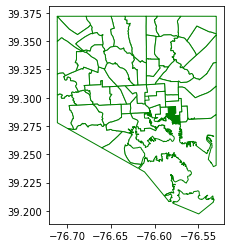

In [29]:
showCSA("Canton")

True

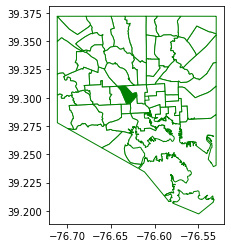

In [30]:
csa="Upton/Druid Heights"
showCSA(csa)

In [31]:
get_All_CSA_ranks(csa)

,Indic,Name,Raw,Rank
paa20,paa20,% Residents Black,88.0215,13
femhhs19,femhhs19,X% Female-Led Households w/ Children Under 18,84.3548,1
mhhi19,mhhi19,Median Household Income,21318.8,55
hhpov19,hhpov19,% Family Households Below Poverty Line,41.6853,1
hhchpov19,hhchpov19,% Children Below Poverty Line,66.5457,1
ownroc20,ownroc20,% Housing Units Owner-Occupied,27.6735,50
vacant20,vacant20,% Residential Properties Vacant and Abandoned,27.0169,4
nohhint19,nohhint19,% Households w/ No Home Internet,31.5955,11
tanf19,tanf19,% Families Receiving TANF,17.5778,4
lifexp18,lifexp18,Life Expectancy,68.4861,45


<h1 style="text-align:center; color:black">Figure 2</h1>
<h1 style="text-align:center; color:red">Page 11</h1>

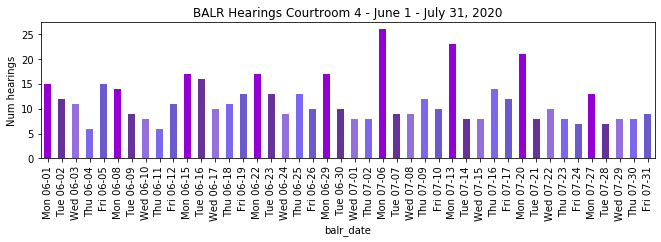

In [32]:
#THIS PRODUCES FIGURE 2 - HEARINGS OBSERVED

#Hearing Dates
fig, ax = plt.subplots()
fig.set_size_inches(11,2.5)
balr_df= all_defs_df.groupby('balr_date')

#Clean up labels and colors
color_dict={0:"darkviolet", 1:"rebeccapurple", 2:"mediumpurple", 3:"mediumslateblue", 4:"slateblue"}
xticks=[]
colors=[]
for x in list(balr_df.groups.keys()):
    #print(x.strftime('%a %m-%d'))
    xticks.append(x.strftime('%a %m-%d'))
    colors.append(color_dict[x.weekday()])

balr_df.size().plot.bar(ax=ax, color=colors, title="BALR Hearings Courtroom 4 - June 1 - July 31, 2020")
ax.set_ylabel("Num hearings")

ax.set_xticklabels(xticks)
pass #Just calling pass to stop the echoing of the xticks

<h1 style="text-align:center; color:red">Page 12</h1>

In [33]:
#Average number of hearings
print("Avg num hearings per day=", round(balr_df["balr_date"].count().mean(),2))

#Median number of hearings
print("Med num hearings per day=", round(balr_df["balr_date"].count().median(),2))

Avg num hearings per day= 11.57
Med num hearings per day= 10.0


<h1 style="text-align: center; color:black">Figure 3</h1>

In [34]:
#This creates Figure 3
a=all_defs_df["Outcome"].value_counts()
b=round(all_defs_df["Outcome"].value_counts(normalize=True)*100,2)

fig_df=pd.DataFrame(a)
fig_df["Pct"]=b.values

fig_df.to_clipboard()
fig_df

,Outcome,Pct
HWOB,313,61.49
UPB,85,16.70
ROR,71,13.95
MONEY,26,5.11
ROR-HDTN,14,2.75


In [35]:
#Stats prosecution recommendations
pros_df = all_defs_df[all_defs_df["asa_rec"]!="-1"]
print("ASA made rec in ", len(pros_df), "cases")
fig_df = pd.DataFrame(pros_df["asa_rec"].value_counts())
fig_df["Pct"]=round(pros_df["asa_rec"].value_counts(normalize=True),2)
fig_df

ASA made rec in  480 cases


,asa_rec,Pct
HWOB,451,0.94
ROR,28,0.06
MONEY,1,0.00


In [36]:
#Stats pretrial recommendations
pretrial_df = all_defs_df[all_defs_df["pretrial_rec"]!="-1"]
print("Pretrial made rec in ", len(pretrial_df), "cases")
fig_df = pd.DataFrame(pretrial_df["pretrial_rec"].value_counts())
fig_df["Pct"]=round(pretrial_df["pretrial_rec"].value_counts(normalize=True),2)
fig_df

Pretrial made rec in  500 cases


,pretrial_rec,Pct
HWOB,377,0.75
ROR,107,0.21
UPB,10,0.02
MONEY,6,0.01


In [37]:
#Judges Following Pretrial Recs
for outcome, sub_df in pretrial_df.groupby("pretrial_rec"):
    n=len(sub_df)
    follow=len(sub_df[sub_df["Outcome"]==outcome])
    print(outcome, "followed in", follow,"of",n,"cases = ("+str(round(follow/n*100,2))+"%)")
    

HWOB followed in 299 of 377 cases = (79.31%)
MONEY followed in 3 of 6 cases = (50.0%)
ROR followed in 46 of 107 cases = (42.99%)
UPB followed in 4 of 10 cases = (40.0%)


In [38]:
#Judges Following ASA Recs
for outcome, sub_df in pros_df.groupby("asa_rec"):
    n=len(sub_df)
    follow=len(sub_df[sub_df["Outcome"]==outcome])
    print(outcome, "followed in", follow,"of",n,"cases = ("+str(round(follow/n*100,2))+"%)")
    

HWOB followed in 281 of 451 cases = (62.31%)
MONEY followed in 1 of 1 cases = (100.0%)
ROR followed in 8 of 28 cases = (28.57%)


<h1 style="text-align:center; color:red">Page 13</h1>
<h1 style="text-align:center; color:black">Figure 4</h1>

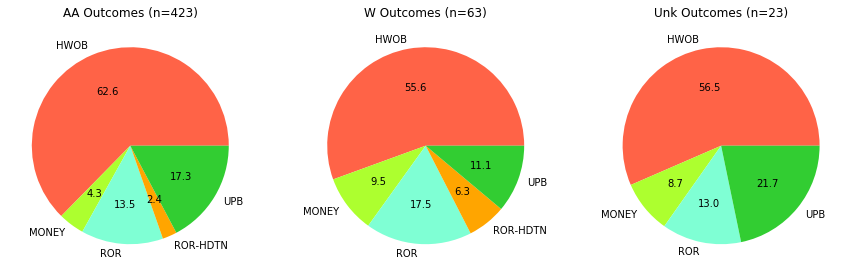

In [39]:
#Code to create figure 4
fig, (ax1, ax2, ax3) = plt.subplots(1,3)

#List of cmaps https://matplotlib.org/stable/tutorials/colors/colormaps.html
std_colors=['tomato', 'greenyellow', 'aquamarine','orange','limegreen']
unk_colors=['tomato', 'greenyellow', 'aquamarine', 'limegreen']

#cmap="tab10"
fig.set_size_inches(15, 5)
all_defs_df[all_defs_df["Race"]=="AA"].groupby("Outcome").size().plot.pie(title="AA Outcomes (n=423)", label="", autopct="%.1f", ax=ax1, colors=std_colors)
all_defs_df[all_defs_df["Race"]=="W"].groupby("Outcome").size().plot.pie(title="W Outcomes (n=63)", label="", autopct="%.1f", ax=ax2, colors=std_colors)
all_defs_df[all_defs_df["Race"]=="Unk"].groupby("Outcome").size().plot.pie(title="Unk Outcomes (n=23)", label="", autopct="%.1f", ax=ax3, colors=unk_colors)

<h1 style="text-align:center; color:red">Page 14</h1>

In [40]:
# load charges data charges
charges_df = pd.read_csv("dc_charges.csv")

In [41]:
#total charges
len(charges_df)

2554

In [42]:
def_series = pd.Series(charges_df["def_index"].unique())
for def_index, sub_df in charges_df.groupby("def_index"):
    def_series[def_index]=len(sub_df["casenumber"].unique())

    #Average number of cases per def
def_series.mean()

1.7509803921568627

In [43]:
#median number of cases per def
def_series.median()

1.0

In [44]:
#number of defs with more than one case
len(def_series[def_series>1])

63

In [45]:
#Just look at top charges
sub_df=charges_df[charges_df.charge_no==1]
len(sub_df)

605

In [46]:
#number of unique charges
len(sub_df["charge_name"].unique())

101

In [47]:
#Classify 
non_viol=set(['CDS: POSS W/I DIST: NARC', 'FIREARM POSS W/FEL CONVICT', 'VIOLATE PROT ORDER', 'REG FIREARM:ILLEGAL POSSESSION', 'LOADED HANDGUN ON PERSON', 'CDS DIST-NARC', 'HANDGUN ON PERSON', 'MOTOR VEH/UNLAWFUL TAKING', 'THEFT: $100 TO UNDER $1,500', 'THEFT LESS THAN $100.00', 'BURGLARY- 4TH DEGREE-DWELL','CDS-POSS OF FIREARMS', 'BURGLARY-THIRD DEGREE', 'FAIL REG OFFENDER/FALSE INFO', 'DRIVING/ATTEMPTING DRIVE MOTOR VEH. ON HWY W/O REQ. LICENSE AND AUTHORIZATION', 'FIREARM/DRUG TRAF CRIME','POSS OF FIREARM MINOR', 'VIOLATE EXPARTE/PROT ORDER', 'BURGLARY/2ND DEGREE/GENERAL', 'CDS: DISTR ETC. W/FIREARM', '(DRIVING, ATTEMPTING TO DRIVE) VEHICLE WHILE UNDER THE INFLUENCE OF ALCOHOL', 'BURGLARY-4TH DEGREE THEFT', 'LOADED HANDGUN IN VEHICLE', 'MAL DEST PROP/VALU < $1,000', 'TRESPASS: PRIVATE PROPERTY', 'BURGLARY-4TH DEGREE-STORE', '(DRIVE, ATTEMPT DRIVE) VEH. WHILE UNDER INFLUENCE OF (ALCOHOL, ALCOHOL PER SE) WHILE TRANSP. MINOR', 'DIST/PWID CDS FENTYL/HEROIN', 'PERSON DRIVING MOTOR VEH. ON (HWY., PUBLIC USE PROPERTY) ON SUSPENDED LIC. AND PRIVILEGE', 'CDS POSS W/INT TO DIST', 'DRIVING, ATTEMPTING TO DRIVE MOTOR VEHICLE ON HIGHWAY WITHOUT REQUIRED LICENSE AND AUTHORIZATION', 'PERSON DRIVING MOTOR VEHICLE ON HIGHWAY OR PUBLIC USE PROPERTY ON SUSPENDED LICENSE AND PRIVILEGE', 'PEACE ORDER: FAIL TO COMPLY', '(DRIVING, ATT.TO DRIVE) VEH. WHILE SO FAR IMPAIRED BY (DRUG(S),DRUG(S)& ALCO.)) CANNOT DRIVE SAFELY', 'CDS DISTRIBUTE - OTHER', 'THEFT: $1,500 TO UNDER $25,000', 'ESCAPE - SECOND DEGREE'])

a2=set(['ASSAULT-SEC DEGREE'])

In [48]:
x=sub_df.charge_name.value_counts(normalize=True).sort_values(ascending = False).head(50)
viol = set(x.index)-non_viol-a2

In [49]:
viol

{'ARMED ROBBERY',
 'ARSON/THREAT',
 'ASSAULT SEC DEG-LE/P&P/FIRE/EM',
 'ASSAULT-FIRST DEGREE',
 'ATT 1ST DEG. MURDER',
 'BURGLARY-FIRST DEGREE',
 'CHILD ABUSE: 2ND DEG -CUST',
 'FIREARM USE/FEL-VIOL CRIME',
 'HOME INVASION',
 'MAL DESTR PROP VALUE $1,000+',
 'MURDER - FIRST DEGREE',
 'RAPE FIRST DEGREE',
 'ROBBERY'}

In [50]:
#Assault 2 raw numbers
sub_df.charge_name.value_counts().sort_values(ascending = False).head(1)

ASSAULT-SEC DEGREE    213
Name: charge_name, dtype: int64

In [51]:
top_50 = sub_df.charge_name.value_counts(normalize=True).sort_values(ascending = False).head(50)
top_50.sum()

0.912396694214876

In [52]:
#Percent top 50 violent
top_50[top_50.index.isin(viol)].sum()

0.2528925619834711

In [53]:
top_50[top_50.index.isin(viol)]

ASSAULT-FIRST DEGREE              0.102479
ROBBERY                           0.034711
ATT 1ST DEG. MURDER               0.034711
MURDER - FIRST DEGREE             0.028099
ARMED ROBBERY                     0.011570
BURGLARY-FIRST DEGREE             0.008264
HOME INVASION                     0.006612
FIREARM USE/FEL-VIOL CRIME        0.006612
ARSON/THREAT                      0.006612
RAPE FIRST DEGREE                 0.003306
CHILD ABUSE: 2ND DEG -CUST        0.003306
MAL DESTR PROP VALUE $1,000+      0.003306
ASSAULT SEC DEG-LE/P&P/FIRE/EM    0.003306
Name: charge_name, dtype: float64

In [54]:
#Percent top 50 non violent
top_50[top_50.index.isin(non_viol)].sum()

0.30743801652892566

In [55]:
#Percent top 50 non violent
top_50[top_50.index.isin(a2)].sum()

0.35206611570247937

In [56]:
sub_df.charge_name.value_counts(normalize=True).sort_values(ascending = False).head(50).sum()

0.912396694214876

In [57]:
# THOMAS JUNES (Richard Green)
findName("Junes")

,Psynym,Race,Outcome,CSA,pretrial_rec,asa_rec
141,Thomas Junes,AA,HWOB,Lauraville,HWOB,HWOB
183,Antwan Junes,Unk,HWOB,Glen-Fallstaff,HWOB,HWOB


In [52]:
all_defs_df.loc[141]

def_index                       141
Name                  Richard Green
Race                             AA
balr_date       2020-06-17 00:00:00
judge_name                    Owens
Outcome                        HWOB
pretrial_rec                   HWOB
asa_rec                        HWOB
Long                       -76.5747
Lat                         39.3489
CSA                      Lauraville
Name: 141, dtype: object

In [58]:
#Junes/Green charges
charges_df[charges_df.def_index==141]

,index,def_index,casenumber,courtsystem,charge_no,cjis_code,charge_name,status,case_disp,plea,charge_disp,charge_disp_date,trialdate,trialtype
1361,1362,141,3B02422927,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,1 0990,MURDER - FIRST DEGREE,CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN
1362,1363,141,3B02422927,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,2,1 1107,MURDER-SECOND DEGREE,CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN
1363,1364,141,3B02422927,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,3,1 1420,ASSAULT-FIRST DEGREE,CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN
1364,1365,141,3B02422927,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,4,1 1415,ASSAULT-SEC DEGREE,CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN
1365,1366,141,3B02422927,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,5,1 5299,FIREARM USE/FEL-VIOL CRIME,CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN
1366,1367,141,3B02422927,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,6,1 5212,HANDGUN ON PERSON,CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN


In [59]:
#Travell Pelliam (Guzman)
findName("Pelliam")

,Psynym,Race,Outcome,CSA,pretrial_rec,asa_rec
168,Travell Pelliam,AA,HWOB,Southeastern,HWOB,HWOB


In [60]:
#Pelliam BALR info
all_defs_df.loc[168]

def_index                       168
Psynym              Travell Pelliam
Race                             AA
balr_date       2020-06-19 00:00:00
judge_name                    Smith
Outcome                        HWOB
pretrial_rec                   HWOB
asa_rec                        HWOB
Long                       -76.5434
Lat                         39.2789
CSA                    Southeastern
Name: 168, dtype: object

In [61]:
#Pelliam chages
charges_df[charges_df.def_index==168]

,index,def_index,casenumber,courtsystem,charge_no,cjis_code,charge_name,status,case_disp,plea,charge_disp,charge_disp_date,trialdate,trialtype
1463,1464,168,4B02416782,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,2 0705,ARMED ROBBERY,CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN
1464,1465,168,4B02416782,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,2,2 0700,ROBBERY,CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN
1465,1466,168,4B02416782,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,3,1 1420,ASSAULT-FIRST DEGREE,CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN
1466,1467,168,4B02416782,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,4,1 1415,ASSAULT-SEC DEGREE,CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN
1467,1468,168,4B02416782,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,5,1A1137,"ATT-THEFT: $100 TO UND $1,500",CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN
1468,1469,168,4B02416782,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,6,1A1136,"ATT-THEFT: $1,500 TO UND $25K",CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN


In [62]:
#Nigel Ingaglia (John Hyman)
findName("Ingaglia")

,Psynym,Race,Outcome,CSA,pretrial_rec,asa_rec
413,Nigel Ingaglia,AA,HWOB,Southern Park Heights,HWOB,HWOB
487,Bruce Ingaglia,AA,HWOB,The Waverlies,HWOB,HWOB


In [63]:
#Hyman balr
all_defs_df.loc[413]

def_index                         413
Psynym                 Nigel Ingaglia
Race                               AA
balr_date         2020-07-20 00:00:00
judge_name                     Scurti
Outcome                          HWOB
pretrial_rec                     HWOB
asa_rec                          HWOB
Long                         -76.6618
Lat                            39.334
CSA             Southern Park Heights
Name: 413, dtype: object

In [64]:
#Hyman charges
charges_df[charges_df.def_index==413]

,index,def_index,casenumber,courtsystem,charge_no,cjis_code,charge_name,status,case_disp,plea,charge_disp,charge_disp_date,trialdate,trialtype
175,175,413,0B02420719,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,2 0480,MOTOR VEH/UNLAWFUL TAKING,CLOSED,JURY TRIAL PRAYED,NaN,NaN,NaN,NaN,NaN
176,176,413,0B02420719,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,2,1 1136,"THEFT: $1,500 TO UNDER $25,000",CLOSED,JURY TRIAL PRAYED,NaN,NaN,NaN,NaN,NaN
177,177,413,0B02420719,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,3,1 1466,UNAUTH REMOVAL OF MV,CLOSED,JURY TRIAL PRAYED,NaN,NaN,NaN,NaN,NaN
447,447,413,1B02420125,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,1 1420,ASSAULT-FIRST DEGREE,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2020-11-18,2021-03-23,NaN
448,448,413,1B02420125,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,2,1 1415,ASSAULT-SEC DEGREE,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2021-03-23,2021-03-23,NaN
449,449,413,1B02420125,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,3,1 1425,RECKLESS ENDANGERMENT,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2021-03-23,2021-03-23,NaN
450,450,413,1B02420125,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,4,1 5200,DANGEROUS WEAPON-INT/INJURE,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2021-03-23,2021-03-23,NaN
566,566,413,1B02423590,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,1 1415,ASSAULT-SEC DEGREE,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2020-08-21,NaN,NaN
850,851,413,2B02422828,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,1 1415,ASSAULT-SEC DEGREE,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2020-09-14,NaN,NaN
851,852,413,2B02422828,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,2,2 0254,VIOLATE PROT ORDER,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2020-09-14,NaN,NaN


<h1 style="text-align:center; color:red">Page 15</h1>

In [65]:
#Alvis Tellman (Aaron Stevenson)
findName("Tellman")

,Psynym,Race,Outcome,CSA,pretrial_rec,asa_rec
85,Alvis Tellman,AA,HWOB,Howard Park/West Arlington,HWOB,HWOB


In [66]:
charges_df[charges_df.def_index==85]

,index,def_index,casenumber,courtsystem,charge_no,cjis_code,charge_name,status,case_disp,plea,charge_disp,charge_disp_date,trialdate,trialtype
98,98,85,0B02419018,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,1 1416,ASSAULT SEC DEG-LE/P&P/FIRE/EM,CLOSED,JURY TRIAL PRAYED,NaN,NaN,NaN,NaN,NaN
99,99,85,0B02419018,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,2,1 1415,ASSAULT-SEC DEGREE,CLOSED,JURY TRIAL PRAYED,NaN,NaN,NaN,NaN,NaN
100,100,85,0B02419018,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,3,1 1415,ASSAULT-SEC DEGREE,CLOSED,JURY TRIAL PRAYED,NaN,NaN,NaN,NaN,NaN
101,101,85,0B02419018,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,4,1 0600,RESIST/INTERFERE WITH ARREST,CLOSED,JURY TRIAL PRAYED,NaN,NaN,NaN,NaN,NaN


True

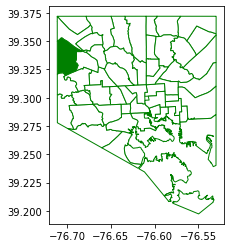

In [67]:
csa="Howard Park/West Arlington"
showCSA(csa)

In [68]:
get_All_CSA_ranks(csa)

,Indic,Name,Raw,Rank
paa20,paa20,% Residents Black,89.495,11
femhhs19,femhhs19,X% Female-Led Households w/ Children Under 18,42.2386,37
mhhi19,mhhi19,Median Household Income,53534.1,21
hhpov19,hhpov19,% Family Households Below Poverty Line,13.3213,30
hhchpov19,hhchpov19,% Children Below Poverty Line,18.6807,33
ownroc20,ownroc20,% Housing Units Owner-Occupied,68.4679,15
vacant20,vacant20,% Residential Properties Vacant and Abandoned,1.74825,31
nohhint19,nohhint19,% Households w/ No Home Internet,28.2857,14
tanf19,tanf19,% Families Receiving TANF,3.80038,41
lifexp18,lifexp18,Life Expectancy,74.7395,16


<h1 style="text-align:center; color:red">Page 16</h1>

In [69]:
#Kevin Scutt (Jarrell Sinkler)
findName("scutt")

,Psynym,Race,Outcome,CSA,pretrial_rec,asa_rec
328,Kevin Scutt,AA,HWOB,False,HWOB,HWOB


In [70]:
charges_df[charges_df.def_index==328]

,index,def_index,casenumber,courtsystem,charge_no,cjis_code,charge_name,status,case_disp,plea,charge_disp,charge_disp_date,trialdate,trialtype
1580,1581,328,4B02420541,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,1 5212,HANDGUN ON PERSON,DEFERRED PAYMENT,TRIAL,OTHER PLEA,STET,2020-09-11,NaN,NaN
1581,1582,328,4B02420541,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,2,1 1455,LOADED HANDGUN ON PERSON,DEFERRED PAYMENT,TRIAL,OTHER PLEA,STET,2020-09-11,NaN,NaN
1582,1583,328,4B02420541,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,3,1 0175,HANDGUN IN VEHICLE,DEFERRED PAYMENT,TRIAL,OTHER PLEA,STET,2020-09-11,NaN,NaN
1583,1584,328,4B02420541,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,4,1 1454,LOADED HANDGUN IN VEHICLE,DEFERRED PAYMENT,TRIAL,GUILTY,GUILTY,2020-09-11,NaN,NaN
1584,1585,328,4B02420541,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,5,1 5285,POSS OF FIREARM MINOR,DEFERRED PAYMENT,TRIAL,OTHER PLEA,STET,2020-09-11,NaN,NaN
1585,1586,328,4B02420541,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,6,NaN,HANDGUN WITHIN 100YDS OF PARKS,DEFERRED PAYMENT,TRIAL,OTHER PLEA,STET,2020-09-11,NaN,NaN
1586,1587,328,4B02420541,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,7,NaN,HANDGUN IN VEH. WITHIN 100YDS,DEFERRED PAYMENT,TRIAL,OTHER PLEA,STET,2020-09-11,NaN,NaN


In [71]:
#Andre Eppurson (Jarrell Snell)
findName("eppurson")

,Psynym,Race,Outcome,CSA,pretrial_rec,asa_rec
433,Andre Eppurson,AA,HWOB,Lauraville,HWOB,HWOB


In [72]:
charges_df[charges_df.def_index==433]

,index,def_index,casenumber,courtsystem,charge_no,cjis_code,charge_name,status,case_disp,plea,charge_disp,charge_disp_date,trialdate,trialtype
456,456,433,1B02420286,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,1 0439,RFL/SHOTGN POSS-DISQUAL,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2020-09-02,NaN,NaN
457,457,433,1B02420286,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,2,1 1285,ILLEGAL POSS AMMO,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2020-09-02,NaN,NaN
458,458,433,1B02420286,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,3,NaN,CARRY A RIFLE IN BALT CITY,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2020-09-02,NaN,NaN


True

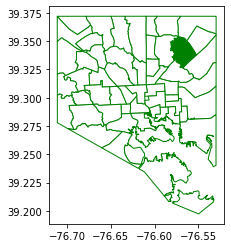

In [73]:
csa="Lauraville"
showCSA(csa)

In [74]:
get_All_CSA_ranks(csa)

,Indic,Name,Raw,Rank
paa20,paa20,% Residents Black,59.3165,31
femhhs19,femhhs19,X% Female-Led Households w/ Children Under 18,36.6667,40
mhhi19,mhhi19,Median Household Income,74759.5,9
hhpov19,hhpov19,% Family Households Below Poverty Line,6.00421,44
hhchpov19,hhchpov19,% Children Below Poverty Line,13.7772,39
ownroc20,ownroc20,% Housing Units Owner-Occupied,71.3323,11
vacant20,vacant20,% Residential Properties Vacant and Abandoned,1.21321,33
nohhint19,nohhint19,% Households w/ No Home Internet,8.76719,48
tanf19,tanf19,% Families Receiving TANF,4.1638,38
lifexp18,lifexp18,Life Expectancy,74.6939,17


In [75]:
#Eppurson days in jail

release = date(2020, 9, 2)
balr = date(2020, 7, 21)
delta = release-balr
delta.days

43

<h1 style="text-align:center; color:red">Page 17</h1>

In [76]:
#Judge Dunn Dates
all_defs_df[all_defs_df.judge_name.str.contains("Dunn")]["balr_date"].unique()

array(['2020-06-02T00:00:00.000000000', '2020-06-11T00:00:00.000000000',
       '2020-07-16T00:00:00.000000000', '2020-07-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [77]:
#Judge Dunn Release Stats
all_defs_df[all_defs_df.judge_name.str.contains("Dunn")]["Outcome"].value_counts()

HWOB     33
MONEY     8
Name: Outcome, dtype: int64

In [78]:
#Judge Dunn Release Stats
all_defs_df[all_defs_df.judge_name.str.contains("Dunn")]["Outcome"].value_counts(normalize=True)

HWOB     0.804878
MONEY    0.195122
Name: Outcome, dtype: float64

<h1 style="text-align:center; color:red">Page 18</h1>

In [79]:
#Number of Judges
len(all_defs_df["judge_name"].unique())

16

In [80]:
#Judge Smith
all_defs_df[all_defs_df["judge_name"]=="Smith"]["Outcome"].value_counts()

HWOB    23
UPB      6
Name: Outcome, dtype: int64

In [81]:
#Judge Smith
all_defs_df[all_defs_df["judge_name"]=="Smith"]["Outcome"].value_counts(normalize=True)

HWOB    0.793103
UPB     0.206897
Name: Outcome, dtype: float64

In [82]:
# All judges - Raw
judges= all_defs_df.judge_name.unique()
columns = all_defs_df.Outcome.unique()
result_df=pd.DataFrame(index=judges, columns=columns)

for judge, sub_df in all_defs_df.groupby("judge_name"):
    result_row=sub_df["Outcome"].value_counts()
    result_df.loc[judge]=result_row
result_df.loc["SUM"]=result_df.sum(axis=0)
result_df=result_df.fillna("-")
result_df

,UPB,HWOB,ROR,MONEY,ROR-HDTN
Boles,9,13.0,1,1,1
Dunn,-,33.0,-,8,-
Studdard,-,40.0,19,2,1
Chen,14,39.0,-,-,-
Green,-,8.0,7,-,-
Baylor-Thompson,2,33.0,23,5,8
Smith,6,23.0,-,-,-
Scurti,32,32.0,-,2,3
Dorsey,-,24.0,9,2,-
Owens,11,19.0,4,-,-


In [83]:
# All judges - Percentages
judges= all_defs_df.judge_name.unique()
columns = all_defs_df.Outcome.unique()
result_df=pd.DataFrame(index=judges, columns=columns)

for judge, sub_df in all_defs_df.groupby("judge_name"):
    result_row=round(sub_df["Outcome"].value_counts(normalize=True)*100,2)
    result_df.loc[judge]=result_row

result_df= result_df.sort_values(by="HWOB", ascending=False)
result_df.loc["AVG"]=result_df.mean(axis=0)
result_df.loc["MED"]=result_df.median(axis=0)
result_df=result_df.fillna("-")
result_df

,UPB,HWOB,ROR,MONEY,ROR-HDTN
Kerry,-,100.000000,-,-,-
Dunn,-,80.490000,-,19.51,-
Smith,20.69,79.310000,-,-,-
Pastore,-,77.780000,11.11,-,11.11
Hengrer,15.38,76.920000,7.69,-,-
Chen,26.42,73.580000,-,-,-
Dorsey,-,68.570000,25.71,5.71,-
Studdard,-,64.520000,30.65,3.23,1.61
Etheridge,37.5,62.500000,-,-,-
Greene,26.09,60.870000,13.04,-,-


<h1 style="text-align:center; color:red">Page 23</h1>
<h1 style="text-align:center; color:black">Figure 5</h1>

In [84]:
#Read DPSCS data
jail_df = pd.read_excel("Jail Data.xlsx", sheet_name="Data")

#Echo first 5 rows
jail_df.head(5)

,County,Date,Year,Intakes,Departures,Last Day Count,Average Daily Population,Pretrial (1-90 days),Pretrial (91+ days),PSI,...,Home detention (average),Weekend (average),Commitments,Suicides,Walkoff,Escapes,Pretrial (total),Sentenced (total),Total Jail Population,Unnamed: 30
0,Allegany,2014-01-01,2014,134.0,129,161.0,150.0,52,29,1,...,8.0,11.0,0,0,0,0.0,81,71,152,Row Labels
1,Anne Arundel,2014-01-01,2014,722.0,722,779.0,803.0,313,114,0,...,56.0,94.0,2,0,0,0.0,427,346,773,NaN
2,Baltimore,2014-01-01,2014,1265.0,1182,1433.0,1366.0,639,200,33,...,34.0,61.0,4,0,0,0.0,839,539,1378,NaN
3,Baltimore City,2014-01-01,2014,2324.0,2304,3686.0,3713.0,1646,1487,84,...,24.0,64.0,18,0,0,0.0,3133,0,3133,NaN
4,Calvert,2014-01-01,2014,446.0,415,329.0,291.0,73,49,3,...,3.0,25.0,0,0,0,0.0,122,180,302,NaN


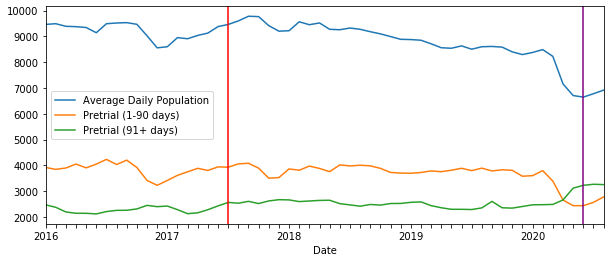

In [85]:
#FIGURE 5
f= jail_df.query("Date.dt.year >= 2016").groupby("Date").sum()[["Average Daily Population", "Pretrial (1-90 days)", "Pretrial (91+ days)"]]
n = f.index.strftime("%Y %m").to_list()

fig, ax = plt.subplots()

f.plot(figsize=(10,4), xticks=n, ax=ax)

ax.axvline(dt.datetime(2017, 7, 1), color="red")
ax.axvline(dt.datetime(2020, 6, 1), color="purple")

<h1 style="text-align:center; color:red">Page 24</h1>

In [86]:
# Get numbers and percentages for HWOB
hwob_df=all_defs_df[all_defs_df.Outcome=="HWOB"]
print(len(hwob_df))
hwob_df.Race.value_counts(normalize=True)

313


AA     0.846645
W      0.111821
Unk    0.041534
Name: Race, dtype: float64

<h1 style="text-align:center; color:black">Figure 6</h1>
<h1 style="text-align:center; color:red">Page 25</h1>

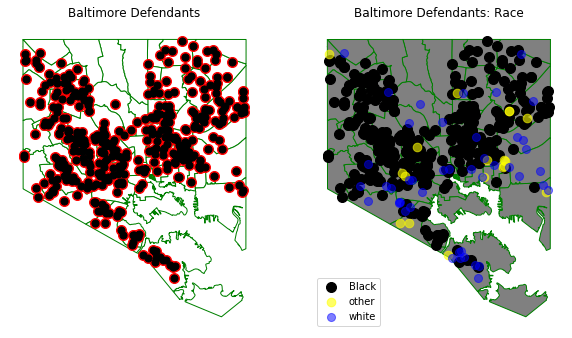

In [87]:

fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,10)

#All Defendants
turbo_gdf.plot(color="white", ax=ax[0], edgecolor="green")
ax[0].scatter(x=balt_x_coords, y=balt_y_coords, s=100, color="red")
ax[0].scatter(x=balt_x_coords, y=balt_y_coords, s=50, color="black")
ax[0].set(title="Baltimore Defendants")
ax[0].set_axis_off()


#Define cohorts for mapping
aa_x_coords = balt_defs[balt_defs.Race=="AA"]["Long"].tolist()
aa_y_coords = balt_defs[balt_defs.Race=="AA"]["Lat"].tolist()
ww_x_coords = balt_defs[balt_defs.Race=="W"]["Long"].tolist()
ww_y_coords = balt_defs[balt_defs.Race=="W"]["Lat"].tolist()
unk_x_coords = balt_defs[balt_defs.Race=="Unk"]["Long"].tolist()
unk_y_coords = balt_defs[balt_defs.Race=="Unk"]["Lat"].tolist()
hwob_x_coords = balt_defs[balt_defs.Outcome=="HWOB"]["Long"].tolist()
hwob_y_coords = balt_defs[balt_defs.Outcome=="HWOB"]["Lat"].tolist()

#Defendants by race
turbo_gdf.plot(color="gray", ax=ax[1], edgecolor="green")

ax[1].scatter(x=aa_x_coords, y=aa_y_coords, s=100, color="black", label="Black")
ax[1].scatter(x=unk_x_coords, y=unk_y_coords, s=75, color="yellow", alpha=.6, label="other")
ax[1].scatter(x=ww_x_coords, y=ww_y_coords, s=65, color="blue", alpha=.5, label="white")

ax[1].set(title="Baltimore Defendants: Race")
ax[1].legend()
ax[1].set_axis_off()



In [88]:
#Baltimore defendants
len(balt_defs)

425

In [89]:
# % of all defendants
425/509

0.8349705304518664

In [90]:
balt_defs.Race.value_counts()

AA     362
W       45
Unk     18
Name: Race, dtype: int64

In [91]:
balt_defs.Race.value_counts(normalize=True)

AA     0.851765
W      0.105882
Unk    0.042353
Name: Race, dtype: float64

In [92]:
balt_defs[balt_defs.Race=="AA"].Outcome.value_counts(normalize=True)

HWOB        0.616022
UPB         0.174033
ROR         0.143646
MONEY       0.038674
ROR-HDTN    0.027624
Name: Outcome, dtype: float64

In [93]:
balt_defs[balt_defs.Race=="W"].Outcome.value_counts(normalize=True)

HWOB        0.600000
ROR         0.133333
UPB         0.111111
MONEY       0.088889
ROR-HDTN    0.066667
Name: Outcome, dtype: float64

In [94]:
balt_defs[balt_defs.Race=="Unk"].Outcome.value_counts(normalize=True)

HWOB     0.555556
UPB      0.222222
ROR      0.166667
MONEY    0.055556
Name: Outcome, dtype: float64

<h1 style="text-align: center; color:black">Figure 7</h1>
<h1 style="text-align: center; color:red">Page 27</h1>

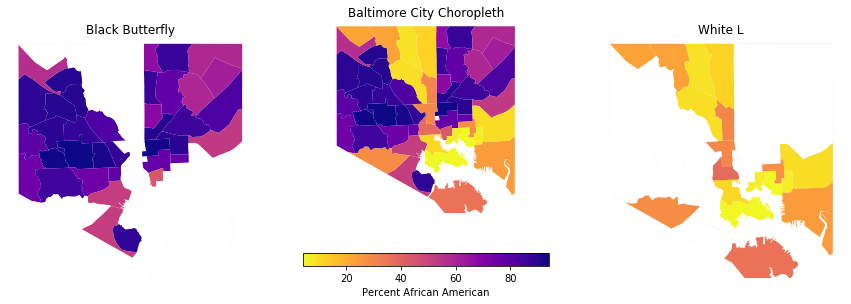

In [95]:
#Draw black butterfly and white L
target="paa20"
fig_rows=1
fig_cols=3
figsize=(fig_cols*5,fig_rows*5)
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=figsize)

default_ylim=(39.225, 39.375)
a=1
b=0
c=2

#This is center map. Uses default, which is to show everything
createCSA_Chloro(axs[a], target)
axs[a].set_ylim(default_ylim) 
axs[a].set_axis_off()
axs[a].set_title("Baltimore City Choropleth")

#This creates Black butterfly
num_show=37
createCSA_Chloro(axs[b], target, num_show)
axs[b].set_ylim(default_ylim) #Kludge from cell above
axs[b].set_axis_off()
axs[b].set_title("Black Butterfly")

#This is the reverse (white L). Note call to Chloro last var TRUE
num_show=18
createCSA_Chloro(axs[c], target, num_show, True)
axs[c].set_ylim(default_ylim)
axs[c].set_axis_off()
axs[c].set_title("White L")

vmax=turbo_gdf[target].max()
vmin=turbo_gdf[target].min()
# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='plasma_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
fig.colorbar(sm, orientation="horizontal", ax=axs[a], label="Percent African American")


In [96]:
#Get Min/Max percentages
paa_min=turbo_gdf["paa20"].min()
min_hood = turbo_gdf[turbo_gdf.paa20==paa_min].index[0]

paa_max=turbo_gdf["paa20"].max()
max_hood = turbo_gdf[turbo_gdf.paa20==paa_max].index[0]

print("Min=", paa_min, min_hood,"  Max=",paa_max, max_hood)


Min= 3.9082412910000004 Canton   Max= 94.17179946 Greater Rosemont


In [97]:
#make a generic function for the three mao

def makeTripleChloro(target, target_title):
    fig_rows=1
    fig_cols=3
    figsize=(fig_cols*5,fig_rows*5)
    fig, axs = plt.subplots(fig_rows, fig_cols, figsize=figsize)

    default_ylim=(39.225, 39.375)
    a=1
    b=0
    c=2

    #This is center map. Uses default, which is to show everything
    createCSA_Chloro(axs[a], target)
    axs[a].set_ylim(default_ylim) 
    axs[a].set_axis_off()
    axs[a].set_title(target_title)

    #This is left map ()
    num_show=37
    createCSA_Chloro(axs[b], target, num_show)
    axs[b].set_ylim(default_ylim) #Kludge from cell above
    axs[b].set_axis_off()
    #axs[b].set_title("Black Butterfly")

    #This is the reverse (white L). Note call to Chloro last var TRUE
    num_show=18
    createCSA_Chloro(axs[c], target, num_show, True)
    axs[c].set_ylim(default_ylim)
    axs[c].set_axis_off()
    #axs[c].set_title("White L")

    vmax=turbo_gdf[target].max()
    vmin=turbo_gdf[target].min()
    # Create colorbar legend
    cmap="plasma_r"
    if getAscend(target):
        cmap="plasma"
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
    # add the colorbar to the figure
    #fig.colorbar(sm, orientation="horizontal", ax=axs[a], label="Percent African American")
    fig.colorbar(sm, orientation="horizontal", ax=axs[a])
    
    return True


In [98]:
#make function that creates triple but on AX passed in, with labels
#Then scatter on top
# From stories

def makeButterfly_el(axs, target, target_title):
    default_ylim=(39.225, 39.375)
    a=1
    b=0
    c=2

    #This is center map. Uses default, which is to show everything
    createCSA_Chloro(axs[a], target)
    axs[a].set_ylim(default_ylim) 
    axs[a].set_axis_off()
    axs[a].set_title(target_title)

    #This is left map ()
    num_show=37
    createCSA_Chloro(axs[b], target, num_show)
    axs[b].set_ylim(default_ylim) #Kludge from cell above
    axs[b].set_axis_off()
    #axs[b].set_title("Black Butterfly")

    #This is the reverse (white L). Note call to Chloro last var TRUE
    num_show=18
    createCSA_Chloro(axs[c], target, num_show, True)
    axs[c].set_ylim(default_ylim)
    axs[c].set_axis_off()
    #axs[c].set_title("White L")

    vmax=turbo_gdf[target].max()
    vmin=turbo_gdf[target].min()
    # Create colorbar legend
    cmap="plasma_r"
    if getAscend(target):
        cmap="plasma"
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
    # add the colorbar to the figure
    #fig.colorbar(sm, orientation="horizontal", ax=axs[a], label="Percent African American")
    fig.colorbar(sm, orientation="horizontal", ax=axs[a])

    return True

In [99]:
# One by One -- Turn into a function
# Vary on what to plot on top ALL, BLACK or HWOB
# Then indicator

def scatterIndicator(indicator, use_x_coords = balt_x_coords, use_y_coords= balt_y_coords, scatter_color="black", scatter_size=15):
    
    title=api_shortname[indicator[:-2]]

    fig_rows=1
    fig_cols=3
    figsize=(fig_cols*5,fig_rows*5)
    fig, axs = plt.subplots(fig_rows, fig_cols, figsize=figsize)
    makeButterfly_el(axs, indicator, title)

    axs[0].scatter(x=use_x_coords, y=use_y_coords, s=scatter_size, color=scatter_color)
    #axs[1].scatter(x=use_x_coords, y=use_y_coords, s=scatter_size, color=scatter_color)
    axs[2].scatter(x=use_x_coords, y=use_y_coords, s=scatter_size, color=scatter_color)
    return axs



<h1 style="text-align: center; color:black">Figure 8</h1>
<h1 style="text-align: center; color:red">Page 28</h1>

Text(0.5, 1, 'Distribution of all Defendants')

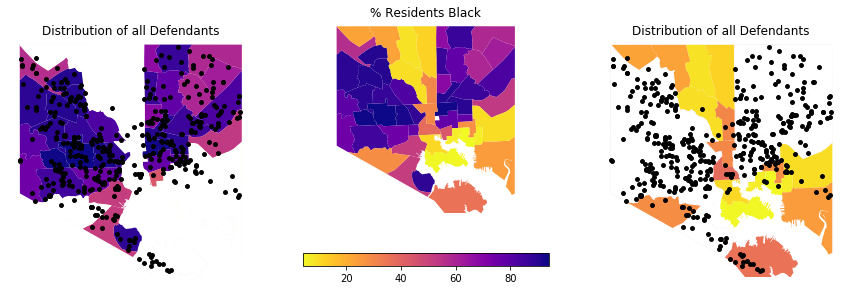

In [100]:
axs = scatterIndicator("paa20")
subtitle="Distribution of all Defendants"
axs[0].set_title(subtitle)
axs[2].set_title(subtitle)

In [101]:
# Correlations for all defs
by="all_defs"
turbo_gdf.corr().sort_values(by=by, ascending=False, key=abs)[by]

all_defs      1.000000
black_defs    0.954851
hwob_defs     0.918589
lifexp18     -0.654898
pubtran19     0.620734
paa20         0.619235
nohhint19     0.609382
voted18      -0.603228
tanf19        0.583968
vacant20      0.578045
mhhi19       -0.566499
femhhs19      0.566019
hhchpov19     0.540131
lesshs19      0.536252
hhpov19       0.534428
novhcl19      0.533766
nilf19        0.513006
abshs19       0.433862
ownroc20     -0.432155
white_defs    0.248757
Name: all_defs, dtype: float64

<h1 style="text-align: center; color:black">Figure 9</h1>
<h1 style="text-align: center; color:red">Page 29</h1>

Text(0.5, 1, 'Distribution of Black Defendants')

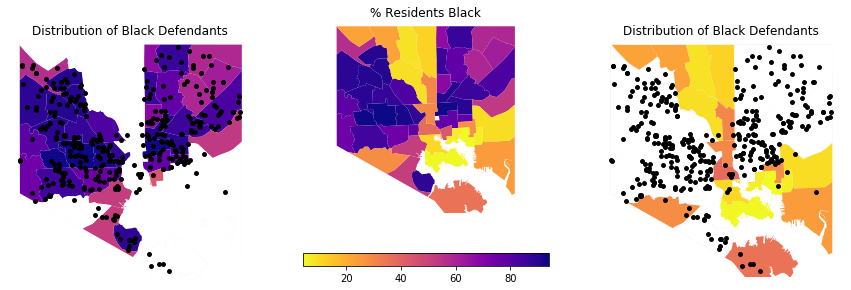

In [102]:
axs = scatterIndicator("paa20", aa_x_coords, aa_y_coords)
subtitle="Distribution of Black Defendants"
axs[0].set_title(subtitle)
axs[2].set_title(subtitle)

In [103]:
len(aa_x_coords)

362

In [104]:
by="black_defs"
turbo_gdf.corr().sort_values(by=by, ascending=False, key=abs)[by]

black_defs    1.000000
all_defs      0.954851
hwob_defs     0.884695
paa20         0.728205
pubtran19     0.664633
lifexp18     -0.637139
femhhs19      0.617603
vacant20      0.610023
tanf19        0.601804
nohhint19     0.597981
mhhi19       -0.564304
novhcl19      0.558330
hhchpov19     0.536868
nilf19        0.533890
hhpov19       0.526104
voted18      -0.525811
lesshs19      0.429468
ownroc20     -0.422404
abshs19       0.377152
white_defs   -0.026644
Name: black_defs, dtype: float64

In [105]:
def getMaxMinInfo(indicator):

    #Get Min/Max percentages
    paa_min=turbo_gdf[indicator].min()
    min_hood = turbo_gdf[turbo_gdf[indicator]==paa_min].index[0]

    paa_max=turbo_gdf[indicator].max()
    max_hood = turbo_gdf[turbo_gdf[indicator]==paa_max].index[0]

    print("Min=", paa_min, min_hood,"  Max=",paa_max, max_hood)
    return True

In [114]:
#Sub DF of stories
stories=[67,82,85,179,213,214,215,267,328,353,433]
story_cols= ["def_index", "Psynym", "Race", "balr_date", "judge_name", "Outcome", "Long", "Lat"]
stories_df=all_defs_df.loc[stories, story_cols].reset_index()
stories_df["CSA"]=stories_df.apply(pullCSA, axis=1)
stories_df

,index,def_index,Psynym,Race,balr_date,judge_name,Outcome,Long,Lat,CSA
0,67,67,Garrett Rabinson,W,2020-06-08,Baylor-Thompson,HWOB,-76.636253,39.331592,Medfield/Hampden/Woodberry/Remington
1,82,82,Dionicio Wordrick,AA,2020-06-10,Smith,HWOB,-76.617872,39.295866,Midtown
2,85,85,Alvis Tellman,AA,2020-06-10,Smith,HWOB,-76.705735,39.332378,Howard Park/West Arlington
3,179,179,Terrence Mirgan,W,2020-06-22,Chen,HWOB,-76.697767,39.363339,Cross-Country/Cheswolde
4,213,213,Kawante Menroe,W,2020-06-25,Chen,HWOB,-76.900626,39.529756,False
5,214,214,Derrick Pewell,AA,2020-06-25,Chen,HWOB,-76.593350,39.358102,Loch Raven
6,215,215,Zoey Griffin,AA,2020-06-25,Chen,HWOB,-76.643680,39.262914,Westport/Mount Winans/Lakeland
7,267,267,HERBERT Smath,AA,2020-07-01,Studdard,HWOB,-76.532532,39.335372,Cedonia/Frankford
8,328,328,Kevin Scutt,AA,2020-07-09,Baylor-Thompson,HWOB,-76.573930,39.388769,False
9,353,353,Michael Parry,W,2020-07-13,Greene,HWOB,-76.659105,39.278461,Allendale/Irvington/S. Hilton


<h1 style="text-align: center; color: black">Figure 10</h1>
<h1 style="text-align: center; color: red">Page 30</h1>

True

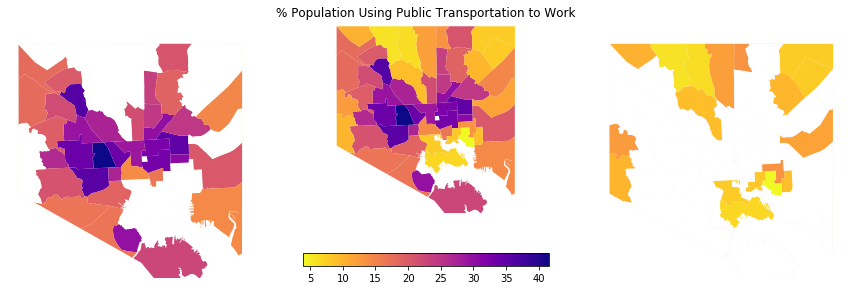

In [106]:
indicator="pubtran19"
title=api_shortname[indicator[:-2]]
fig_rows=1
fig_cols=3
figsize=(fig_cols*5,fig_rows*5)
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=figsize)
makeButterfly_el(axs, indicator, title)


In [107]:
#Correlation coefficient between two indicators
turbo_gdf.corr().loc["paa20","pubtran19"]

0.6861318606140289

In [108]:
turbo_gdf.corr().loc["all_defs","pubtran19"]

0.620734401358255

In [109]:
turbo_gdf.corr().loc["black_defs","pubtran19"]

0.6646326281752315

<h1 style="text-align: center; color: black">Figure 11</h1>
<h1 style="text-align: center; color: red">Page 31</h1>

Min= 3.8434661080000003 Canton   Max= 41.52684564 Sandtown-Winchester/Harlem Park


Text(0.5, 1, 'All Defendants')

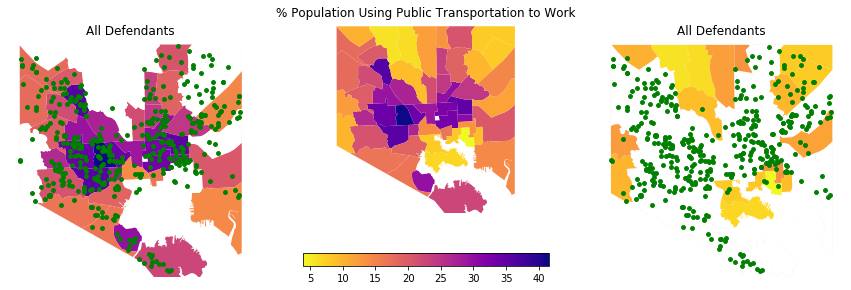

In [115]:
#def scatterIndicator(indicator, use_x_coords = balt_x_coords, use_y_coords= balt_y_coords, scatter_color="black", scatter_size=15)

indicator = "pubtran19"
getMaxMinInfo(indicator)

#Public Transportation
axs=scatterIndicator(indicator, balt_x_coords, balt_y_coords, "green")
title="All Defendants"
axs[0].set_title(title)
axs[2].set_title(title)


<h1 style="text-align: center; color: black">Figure 12</h1>
<h1 style="text-align: center; color: red">Page 32</h1>

Min= 21318.79696 Upton/Druid Heights   Max= 128460.4821 Canton


index                         267
def_index                     267
Psynym              HERBERT Smath
Race                           AA
balr_date     2020-07-01 00:00:00
judge_name               Studdard
Outcome                      HWOB
Long                     -76.5325
Lat                       39.3354
CSA             Cedonia/Frankford
Name: 7, dtype: object

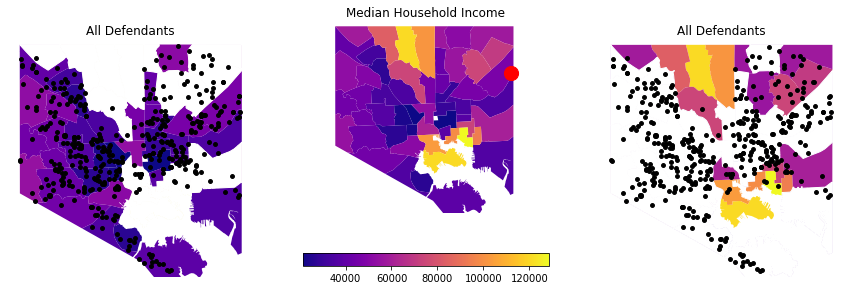

In [116]:
#Median Household Income
indicator = "mhhi19"
getMaxMinInfo(indicator)
axs=scatterIndicator(indicator)

title="All Defendants"
axs[0].set_title(title)
axs[2].set_title(title)

#Scatter code (Quontes Hoffler)
story=7
x=stories_df.loc[story,"Long"]
y=stories_df.loc[story,"Lat"]
axs[1].scatter(x=x, y=y, s=200, color="red")
stories_df.loc[story]


In [119]:
turbo_gdf.corr().loc["mhhi19", ["pubtran19", "paa20", "all_defs", "black_defs"]]

pubtran19    -0.773399
paa20        -0.755885
all_defs     -0.566499
black_defs   -0.564304
Name: mhhi19, dtype: float64

In [120]:
get_All_CSA_ranks("Cedonia/Frankford")

,Indic,Name,Raw,Rank
paa20,paa20,% Residents Black,82.5963,19
femhhs19,femhhs19,X% Female-Led Households w/ Children Under 18,44.2226,34
mhhi19,mhhi19,Median Household Income,47258,25
hhpov19,hhpov19,% Family Households Below Poverty Line,10.8764,34
hhchpov19,hhchpov19,% Children Below Poverty Line,17.9056,35
ownroc20,ownroc20,% Housing Units Owner-Occupied,68.8165,14
vacant20,vacant20,% Residential Properties Vacant and Abandoned,1.19142,35
nohhint19,nohhint19,% Households w/ No Home Internet,16.4387,37
tanf19,tanf19,% Families Receiving TANF,6.41655,29
lifexp18,lifexp18,Life Expectancy,71.8407,32


In [121]:
#Smath (Hoffler)
charges_df[charges_df.def_index==267]

,index,def_index,casenumber,courtsystem,charge_no,cjis_code,charge_name,status,case_disp,plea,charge_disp,charge_disp_date,trialdate,trialtype
168,168,267,0B02420565,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,2 0105,PEACE ORDER: FAIL TO COMPLY,CLOSED,TRIAL,OTHER PLEA,DISMISSED,2020-09-24,NaN,NaN


<h1 style="text-align: center; color: black">Figure 13</h1>
<h1 style="text-align: center; color: red">Page 33</h1>

In [122]:
top_indic =["paa20","pubtran19","mhhi19", "tanf19","vacant20", "hhchpov19"]

x=top_indic[0:3]
x.append("all_defs")
ans=round(turbo_gdf.corr().loc[x,x],2)
ans.to_clipboard()
ans

,paa20,pubtran19,mhhi19,all_defs
paa20,1.00,0.69,-0.76,0.62
pubtran19,0.69,1.00,-0.77,0.62
mhhi19,-0.76,-0.77,1.00,-0.57
all_defs,0.62,0.62,-0.57,1.00


<h1 style="text-align: center; color: black">Figure 14</h1>
<h1 style="text-align: center; color: red">Page 33</h1>

In [123]:
x=["tanf19", "nohhint19", "voted18", "all_defs"]
ans=round(turbo_gdf.corr().loc[x,x],2)
ans.to_clipboard()
ans

,tanf19,nohhint19,voted18,all_defs
tanf19,1.00,0.72,-0.81,0.58
nohhint19,0.72,1.00,-0.79,0.61
voted18,-0.81,-0.79,1.00,-0.60
all_defs,0.58,0.61,-0.60,1.00


In [124]:
for indic in x[:-1]:
    print(indic, api_shortname[indic[:-2]])
    getMaxMinInfo(indic)

tanf19 % Families Receiving TANF
Min= 0.363901019 Canton   Max= 18.65889213 Cherry Hill
nohhint19 % Households w/ No Home Internet
Min= 3.9632213060000003 Greater Roland Park/Poplar Hill   Max= 38.84334146 Sandtown-Winchester/Harlem Park
voted18 % Over 18 Population Voted General Election
Min= 27.97988265 Brooklyn/Curtis Bay/Hawkins Point   Max= 70.61371841 Greater Roland Park/Poplar Hill


In [125]:
def Triple_scatterIndicator(indicators, use_x_coords = balt_x_coords, use_y_coords= balt_y_coords, scatter_color="black", scatter_size=15):
    titles=[]
    for indic in indicators:
        titles.append(api_shortname[indic[:-2]])

    fig_rows=len(indicators)
    fig_cols=3
    figsize=(fig_cols*5,fig_rows*5)
    fig, axs = plt.subplots(fig_rows, fig_cols, figsize=figsize)
    for n in range (fig_rows):
        makeButterfly_el(axs[n,], indicators[n], titles[n])
        axs[n, 0].scatter(x=use_x_coords, y=use_y_coords, s=scatter_size, color=scatter_color)
        axs[n, 2].scatter(x=use_x_coords, y=use_y_coords, s=scatter_size, color=scatter_color)
    return axs


<h1 style="text-align: center; color: black">Figure 15</h1>
<h1 style="text-align: center; color: red">Page 34</h1>

Min= 63.1591764 Downtown/Seton Hill   Max= 84.71839043 Cross-Country/Cheswolde


index                          82
def_index                      82
Psynym          Dionicio Wordrick
Race                           AA
balr_date     2020-06-10 00:00:00
judge_name                  Smith
Outcome                      HWOB
Long                     -76.6179
Lat                       39.2959
CSA                       Midtown
Name: 1, dtype: object

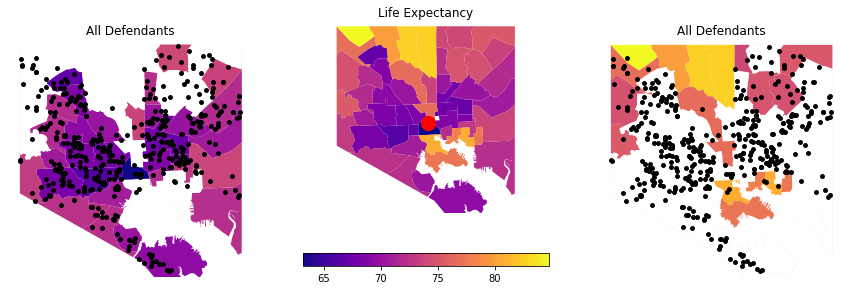

In [127]:
#Life Expectancy
indicator = "lifexp18"
getMaxMinInfo(indicator)
axs=scatterIndicator(indicator)

title="All Defendants"
axs[0].set_title(title)
axs[2].set_title(title)

story=1 #(Quinton Hagans)
x=stories_df.loc[story,"Long"]
y=stories_df.loc[story,"Lat"]
axs[1].scatter(x=x, y=y, s=200, color="red")
stories_df.loc[story]

In [128]:
turbo_gdf.corr().loc["lifexp18", ["paa20", "all_defs"]]

paa20      -0.680775
all_defs   -0.654898
Name: lifexp18, dtype: float64

lifexp18 Life Expectancy
Min= 63.1591764 Downtown/Seton Hill   Max= 84.71839043 Cross-Country/Cheswolde
vacant20 % Residential Properties Vacant and Abandoned
Min= 0.099009900990099 Greater Roland Park/Poplar Hill   Max= 31.951871657754 Sandtown-Winchester/Harlem Park


index                          82
def_index                      82
Psynym          Dionicio Wordrick
Race                           AA
balr_date     2020-06-10 00:00:00
judge_name                  Smith
Outcome                      HWOB
Long                     -76.6179
Lat                       39.2959
CSA                       Midtown
Name: 1, dtype: object

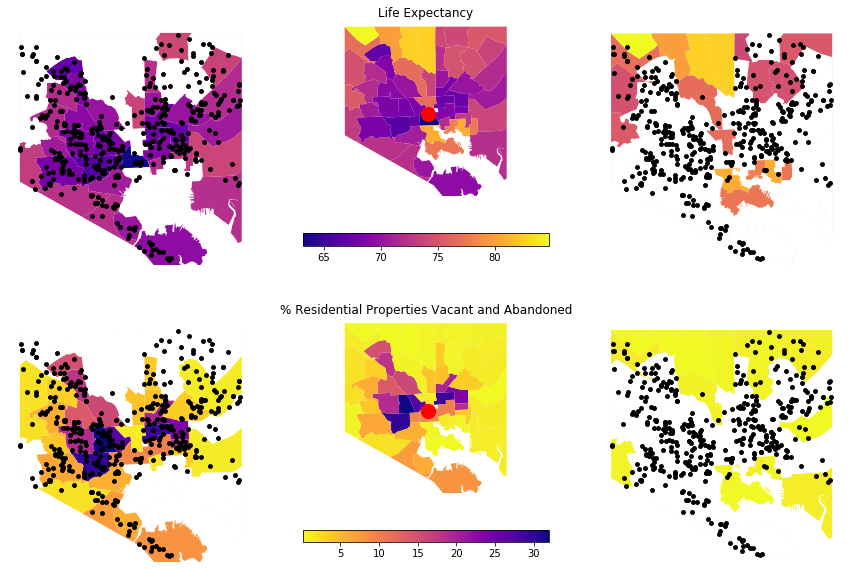

In [129]:
indicators=["lifexp18", "vacant20"]
for indic in indicators:
    print(indic, api_shortname[indic[:-2]])
    getMaxMinInfo(indic)
axs= Triple_scatterIndicator(indicators)

story=1
x=stories_df.loc[story,"Long"]
y=stories_df.loc[story,"Lat"]
axs[0,1].scatter(x=x, y=y, s=200, color="red")
axs[1,1].scatter(x=x, y=y, s=200, color="red")
stories_df.loc[story]


In [130]:
get_All_CSA_ranks("Midtown")

,Indic,Name,Raw,Rank
paa20,paa20,% Residents Black,29.8965,41
femhhs19,femhhs19,X% Female-Led Households w/ Children Under 18,28.6031,45
mhhi19,mhhi19,Median Household Income,53663.7,20
hhpov19,hhpov19,% Family Households Below Poverty Line,6.52288,41
hhchpov19,hhchpov19,% Children Below Poverty Line,13.172,41
ownroc20,ownroc20,% Housing Units Owner-Occupied,40.3318,39
vacant20,vacant20,% Residential Properties Vacant and Abandoned,1.17277,36
nohhint19,nohhint19,% Households w/ No Home Internet,12.4286,44
tanf19,tanf19,% Families Receiving TANF,5.3407,32
lifexp18,lifexp18,Life Expectancy,76.7051,11


<h1 style="text-align: center; color: red">Page 36</h1>

In [131]:
# Get Summer Research
summer_df = pd.read_csv("summer2021_coda.csv")
summer_df

,Casenumber,BALR Date,Judge Name,Outcome,Race,Pretrial Rec,ASA rec,Def rec
0,6B02430581,2021-05-18,Etheridge,UPB,Unknown,ROR,NB,ROR HD
1,3B02438320,2021-05-18,Etheridge,HWOB,AA,NB,HD,ROR
2,1B02438577,2021-05-18,Etheridge,HWOB,AA,NB,NB,UPB with pretrial supervision
3,4B02436193,2021-05-18,Etheridge,HWOB,AA,NB,NB,UPB and stay away
4,0B02438576,2021-05-18,Etheridge,HWOB,AA,NB,NB,UPB
...,...,...,...,...,...,...,...,...
111,UNABLE TO CONFIRM NAME OR CASE NUMBER,2021-06-01,Greene,HWOB,NaN,NB,NB,ROR
112,D023CR21000548,2021-06-01,Greene,UPB,AA,NB - high risk,HD,ROR
113,4B02438664,2021-06-01,Greene,UPB,AA,NB - high risk,HD,ROR
114,2B02438662,2021-06-01,Greene,UPB,AA,NB - low risk,NB,ROR


In [132]:
#Find incomplete values
summer_df[summer_df.Race.isna()]

,Casenumber,BALR Date,Judge Name,Outcome,Race,Pretrial Rec,ASA rec,Def rec
17,NA - 2103252,2021-05-20,Studdard,HWOB,NaN,NB - high risk,NB,No recommendation
90,unk,2021-05-26,Dorsey,HWOB,NaN,No recommendation,No recommendation,No recommendation
111,UNABLE TO CONFIRM NAME OR CASE NUMBER,2021-06-01,Greene,HWOB,NaN,NB,NB,ROR
115,1B02435560,2021-06-11,Dunn,HWOB,NaN,ROR,HD,HD


In [133]:
#Drop incomplete
summer_df=summer_df.drop([17,111, 90, 115])

In [134]:
#Total number of hearings
len(summer_df)

112

In [135]:
#Total number of judges
len(summer_df["Judge Name"].unique())

10

In [136]:
#Outcome percentages
a=summer_df["Outcome"].value_counts()
b=round(summer_df["Outcome"].value_counts(normalize=True)*100,2)

fig_df=pd.DataFrame(a)
fig_df["Pct"]=b.values

fig_df.to_clipboard()
fig_df

,Outcome,Pct
HWOB,78,70.91
ROR,16,14.55
UPB,14,12.73
HD,1,0.91
Bond,1,0.91


In [137]:
#Race percentages
a=summer_df["Race"].value_counts()
b=round(summer_df["Race"].value_counts(normalize=True)*100,2)

fig_df=pd.DataFrame(a)
fig_df["Pct"]=b.values

fig_df.to_clipboard()
fig_df

,Race,Pct
AA,95,84.82
White,9,8.04
Unknown,8,7.14


In [138]:
#Black HWOB rate
round(summer_df[summer_df.Race=="AA"]["Outcome"].value_counts(normalize=True),2)

HWOB    0.75
ROR     0.15
UPB     0.09
HD      0.01
Name: Outcome, dtype: float64

In [139]:
#White HWOB rate
round(summer_df[summer_df.Race=="White"]["Outcome"].value_counts(normalize=True),2)

HWOB    0.62
UPB     0.25
ROR     0.12
Name: Outcome, dtype: float64

In [140]:
# Days of study
summer_df["BALR Date"].unique()

array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
       '2021-05-24', '2021-05-25', '2021-05-26', '2021-05-27',
       '2021-05-28', '2021-06-01'], dtype=object)

In [141]:
len(summer_df["BALR Date"].unique())

10

In [142]:
# Original Study All judges - Percentages
judges= all_defs_df.judge_name.unique()
columns = all_defs_df.Outcome.unique()
result_df=pd.DataFrame(index=judges, columns=columns)

for judge, sub_df in all_defs_df.groupby("judge_name"):
    result_row=round(sub_df["Outcome"].value_counts(normalize=True)*100,2)
    result_df.loc[judge]=result_row

result_df= result_df.sort_values(by="HWOB", ascending=False)
result_df.loc["AVG"]=result_df.mean(axis=0)
result_df.loc["MED"]=result_df.median(axis=0)
result_df=result_df.fillna("-")
result_df

,UPB,HWOB,ROR,MONEY,ROR-HDTN
Kerry,-,100.000000,-,-,-
Dunn,-,80.490000,-,19.51,-
Smith,20.69,79.310000,-,-,-
Pastore,-,77.780000,11.11,-,11.11
Hengrer,15.38,76.920000,7.69,-,-
Chen,26.42,73.580000,-,-,-
Dorsey,-,68.570000,25.71,5.71,-
Studdard,-,64.520000,30.65,3.23,1.61
Etheridge,37.5,62.500000,-,-,-
Greene,26.09,60.870000,13.04,-,-


In [143]:
result_df = result_df.drop(["AVG","MED"])

In [144]:
#Number of judges with higher than 70% HWOB rate
len(result_df[result_df.HWOB>70])

6

In [145]:
#Percent holding > 70%
6/16

0.375

In [146]:
# Summer Study All judges - Percentages
judges= summer_df["Judge Name"].unique()
columns = summer_df.Outcome.unique()
result_df=pd.DataFrame(index=judges, columns=columns)

for judge, sub_df in summer_df.groupby("Judge Name"):
    result_row=round(sub_df["Outcome"].value_counts(normalize=True)*100,2)
    result_df.loc[judge]=result_row

result_df= result_df.sort_values(by="HWOB", ascending=False)
result_df.loc["AVG"]=result_df.mean(axis=0)
result_df.loc["MED"]=result_df.median(axis=0)
result_df=result_df.fillna(0)
result_df

/Users/colinstarger/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


,UPB,HWOB,ROR,NaN,Bond,HD
Studdard,0.000,88.240000,11.760000,0,0.00,0.0
Taylor,0.000,83.330000,16.670000,0,0.00,0.0
O'Hara,0.000,81.820000,18.180000,0,0.00,0.0
Etheridge,20.000,80.000000,0.000000,0,0.00,0.0
Green,0.000,78.260000,21.740000,0,0.00,0.0
Smith,12.500,75.000000,0.000000,0,0.00,12.5
O'Malley,0.000,72.730000,18.180000,0,9.09,0.0
Scurti,50.000,42.860000,7.140000,0,0.00,0.0
Dorsey,14.290,42.860000,42.860000,0,0.00,0.0
Greene,100.000,0.000000,0.000000,0,0.00,0.0


In [147]:
result_df = result_df.drop(["AVG","MED"])

print("Number of judge", len(result_df))

#Number of judges with higher than 70% HWOB rate
len(result_df[result_df.HWOB>70])

Number of judge 10


7

In [148]:
#percent judges higher than 70%
7/10

0.7

# END